In [1]:
import sys
import time
import torch
import numpy as np
import pandas as pd
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt


In [2]:
# set random seed
torch.manual_seed(1)
np.random.seed(1)

In [3]:
# import custom modules
from utils.flutil import Flutils as flutils
from utils.modelutil import ModelUtils as modelutils
from utils.modelutil import FashionMNISTCNN

In [4]:
model_global = FashionMNISTCNN()

In [5]:
# print model architecture
print(model_global)

FashionMNISTCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [6]:
layer_name = "fc.weight"
global_params = model_global.state_dict()[layer_name]

In [7]:
global_params.shape

torch.Size([10, 1568])

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [9]:
# Model training constants
batch_size = 32
lr = 1e-3
num_epochs = 2


# FL constants
num_clients = 50
num_malicious = 10
rounds = 5
defend_model = True

In [10]:
# Prepare attacks
clients_attack = [False for _ in range(num_clients)]

# Randomly select malicious clients
malicious_clients = np.random.choice(num_clients, num_malicious, replace=False)
for i in malicious_clients:
    clients_attack[i] = True

In [11]:
print(f"Malicious clients: {malicious_clients}")

Malicious clients: [27 35 40 38  2  3 48 29 46 31]


In [12]:
clients_attack

[False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False]

In [13]:
# Load data
trainset, testset, trainloader, testloader = modelutils.load_data(batch_size=batch_size)

# prepare clients train loader
trainset_split = random_split(trainset, [int(len(trainset) / num_clients) for _ in range(num_clients)])
client_trainloaders = [DataLoader(x, batch_size=batch_size, shuffle=True) for x in trainset_split]

Round 0 	 Average loss: 1.034 	 Time: [22.38] 

Defending against attack
Malicious clients: [False False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False  True False False False  True
 False False  True False  True False False False False False  True False
  True False]


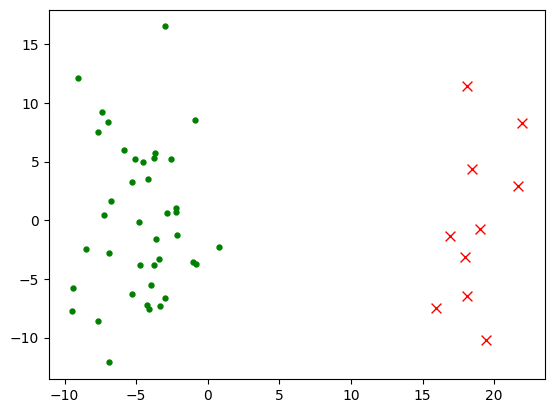

Round 1 	 Average loss: 0.921 	 Time: [22.18] 

Defending against attack
Malicious clients: [False False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False  True False False False  True
 False False  True False  True False False False False False  True False
  True False]


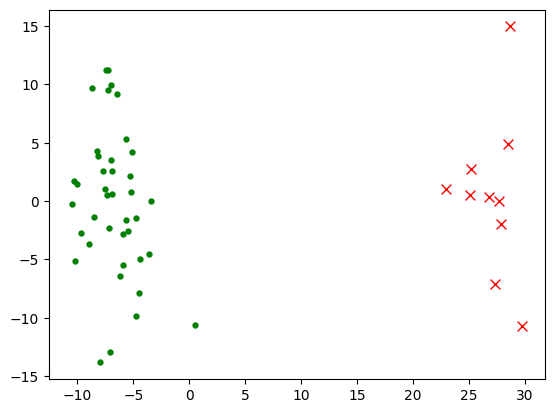

Round 2 	 Average loss: 0.875 	 Time: [22.13] 

Defending against attack
Malicious clients: [False False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False  True False False False  True
 False False  True False  True False False False False False  True False
  True False]


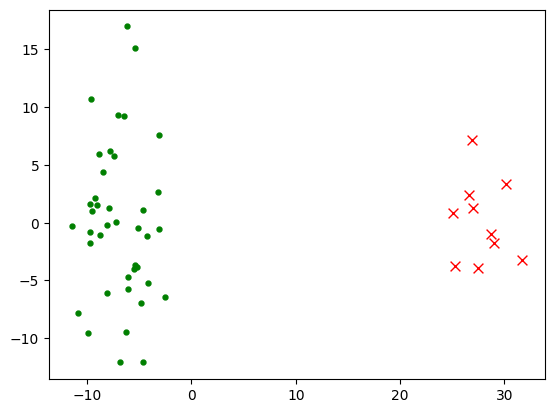

Round 3 	 Average loss: 0.845 	 Time: [22.44] 

Defending against attack
Malicious clients: [False False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False  True False False False  True
 False False  True False  True False False False False False  True False
  True False]


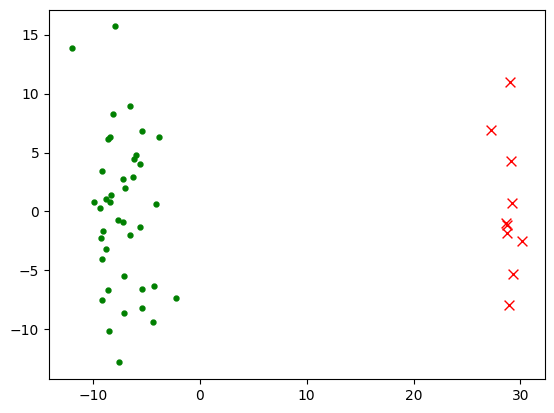

Round 4 	 Average loss: 0.824 	 Time: [22.22] 

Defending against attack
Malicious clients: [False False  True  True False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False  True False  True False False False  True
 False False  True False  True False False False False False  True False
  True False]


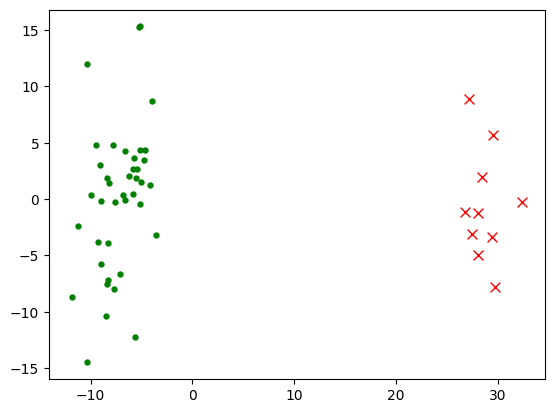

<Figure size 640x480 with 0 Axes>

In [14]:
train_losses = []
model_test_acc  = []
model_global = FashionMNISTCNN()
# list of list to collect the loss of each clients
clients_loss = [[] for _ in range(num_clients)]
for r in range(rounds):
    round_loss = 0.0
    client_models = []
    start = time.time()
    for i in range(num_clients):
        # create a model
        model = FashionMNISTCNN()
        model.to(device)
        # Train Loader
        trainloader = client_trainloaders[i]
        model.load_state_dict(model_global.state_dict())

        # Define optimizer and loss
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        
        loss = modelutils.modelTrainer(
            model=model, 
            num_epochs=num_epochs, 
            trainloader=trainloader, 
            optimizer=optimizer, 
            criterion=criterion,  
            device=device, 
            attack=clients_attack[i])[-1]
        client_models.append(model)
        round_loss += loss
        clients_loss[i].append(loss)
        # print(f"client [{i}] trained, round {r} \t final loss: {round(loss, 3)} \t time: [{round(end, 2)}] \n")
    print(f"Round {r} \t Average loss: {round(round_loss / num_clients, 3)} \t Time: [{round(time.time() - start, 2)}] \n")
    train_losses.append(round_loss / num_clients)
    model_global.load_state_dict(flutils.aggregateModel(client_models, model_global, defend_model))
    model_test_acc.append(modelutils.test_total_accuracy(model_global, testloader, device))   

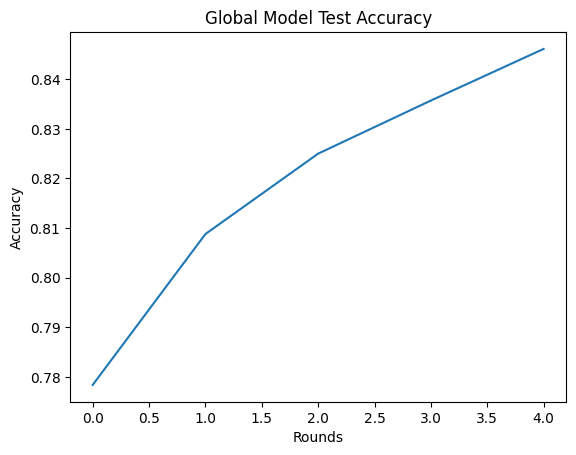

In [15]:
# plot model_test_acc
plt.plot(model_test_acc)
plt.title("Global Model Test Accuracy")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.show()

Text(0, 0.5, 'Loss')

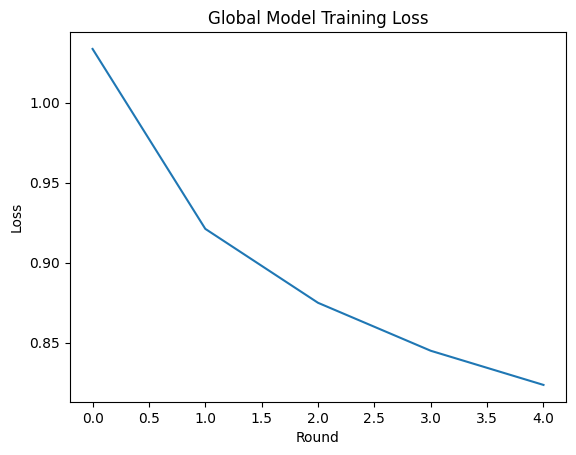

In [16]:
# print and plot training losses for the global model
plt.plot(train_losses)
plt.title("Global Model Training Loss")
plt.xlabel("Round")
plt.ylabel("Loss")

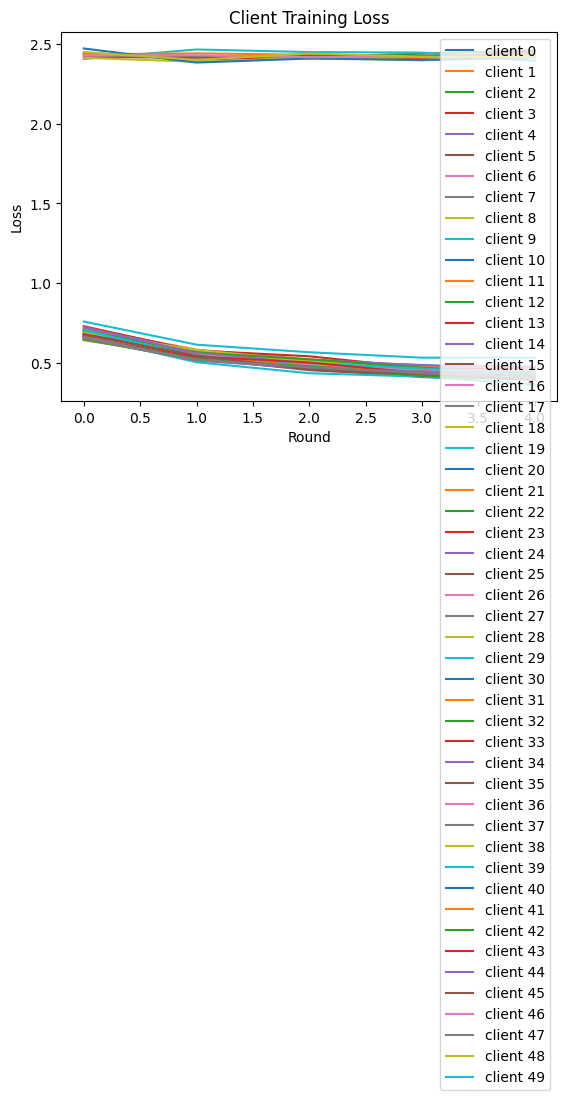

In [17]:
# Plot the loss of each client
for i in range(num_clients):
    plt.plot(clients_loss[i])
    plt.title("Client Training Loss")
    plt.xlabel("Round")
    plt.ylabel("Loss")
plt.legend([f"client {i}" for i in range(num_clients)])
plt.show()